### Import Library


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import warnings
import os
warnings.filterwarnings('ignore')
%matplotlib inline


### EDA


In [2]:
df_train = pd.read_csv("data/Housing_dataset_train.csv")
print(df_train.shape)
df_train.head(3)


(14000, 7)


,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814


In [3]:
df_test = pd.read_csv("data/Housing_dataset_test.csv")
print(df_test.shape)
df_test.head()


(6000, 6)


,ID,loc,title,bedroom,bathroom,parking_space
0,845,Kano,Penthouse,4,1,2
1,1924,Adamawa,Apartment,2,2,4
2,10718,Adamawa,Bungalow,2,7,2
3,12076,Lagos,Mansion,9,5,2
4,12254,Gombe,Semi-detached duplex,5,6,1


In [4]:
df_test["price"] = "test"


In [5]:
# join test and train data
df = pd.concat([df_train, df_test], axis=0, sort=False)
df.head()


,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


In [6]:
df.shape


(20000, 7)

In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 5999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             20000 non-null  int64  
 1   loc            18187 non-null  object 
 2   title          18278 non-null  object 
 3   bedroom        18201 non-null  float64
 4   bathroom       18195 non-null  float64
 5   parking_space  18189 non-null  float64
 6   price          20000 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 1.2+ MB


### Check for missing Values


In [8]:
df.isna().sum()


ID                  0
loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

### Check for redundancy and irregularities in column elements


In [9]:
# a for loop to iterate through the columns in the dataframe and do the value_counts() for each column
# and print out the results
for col in df.columns:
    print(df[col].value_counts())
    print()


2221     3
784      3
1494     3
908      3
2874     3
        ..
9378     1
7118     1
8383     1
7413     1
11736    1
Name: ID, Length: 13000, dtype: int64

Anambra        543
Benue          543
Borno          539
Kaduna         536
Ogun           530
Oyo            524
Nasarawa       521
Kano           521
Katsina        520
Bauchi         517
Adamawa        516
Kebbi          516
Zamfara        513
Cross River    512
Yobe           512
Ondo           511
Osun           506
Ekiti          506
Lagos          502
Gombe          501
Imo            500
Bayelsa        499
Kogi           498
Plateau        497
Delta          494
Ebonyi         493
Jigawa         492
Niger          489
Sokoto         489
Abia           487
Akwa Ibom      484
Enugu          483
Taraba         482
Kwara          477
Rivers         467
Edo            467
Name: loc, dtype: int64

Flat                    2026
Mansion                 1995
Townhouse               1980
Apartment               1973
Semi-detached d

### EDA


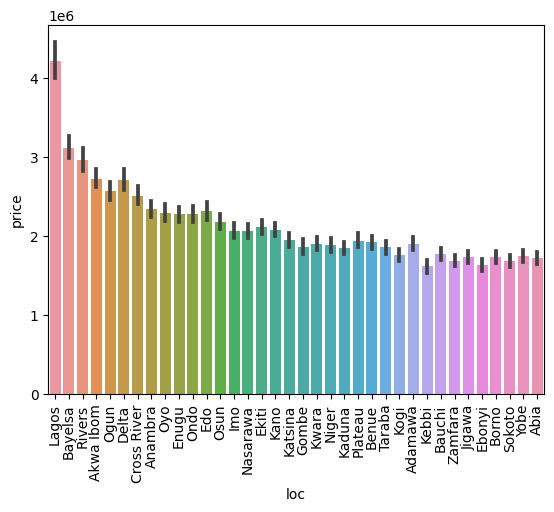

In [10]:
df_sorted = df_train.sort_values(by="price", ascending=False)
sns.barplot(x="loc", y="price", data=df_sorted)
plt.xticks(rotation=90)
plt.show()


<AxesSubplot:xlabel='price', ylabel='Density'>

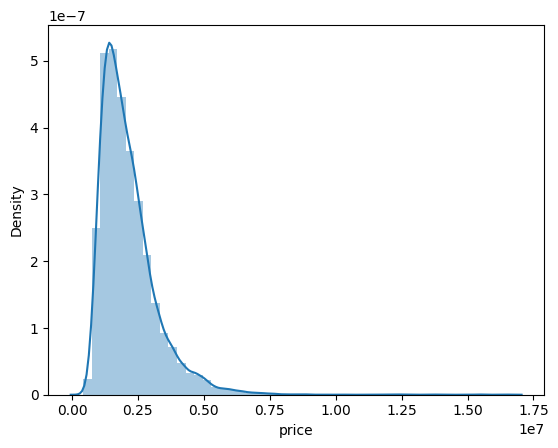

In [11]:
#plot the distribution of house price with seaborn
sns.distplot(df_train['price'])


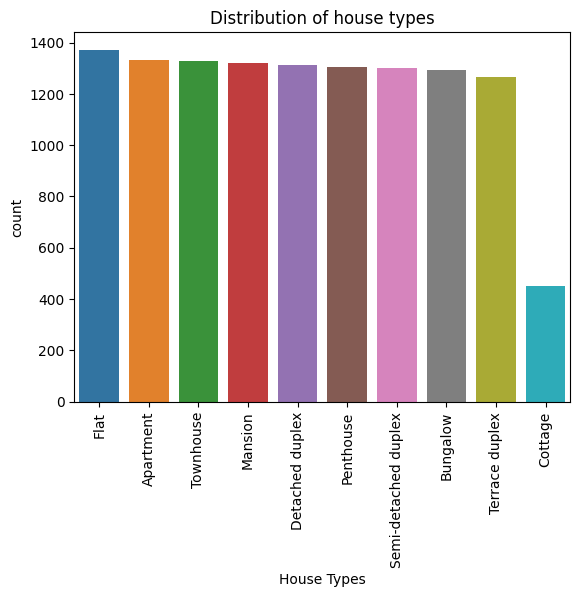

In [18]:
#plot the distribution of house types in descending order
sns.countplot(x="title", data=df_train, order=df_train['title'].value_counts().index)
plt.title(label="Distribution of house types")
plt.xlabel("House Types")
plt.xticks(rotation=90)
plt.show()


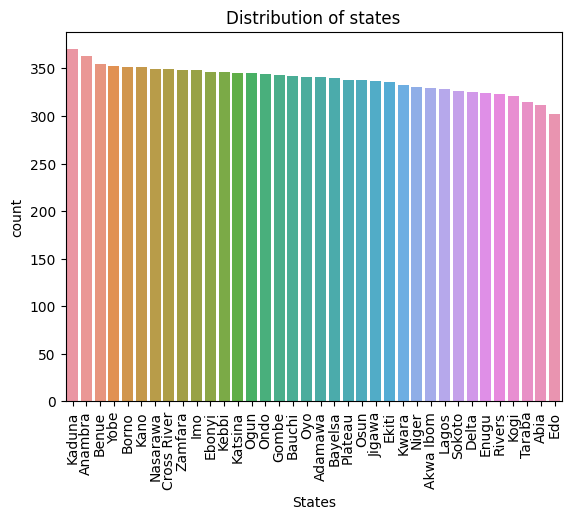

In [23]:
sns.countplot(data=df_train, x="loc", order = df_train['loc'].value_counts().index)
plt.title(label="Distribution of states")
plt.xlabel("States")
plt.xticks(rotation=90)
plt.show()

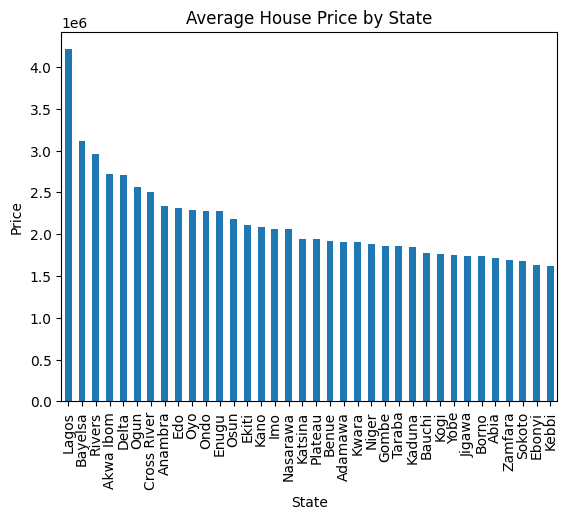

In [26]:
# What is the average house price in each state

df_train.groupby('loc')['price'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Average House Price by State')
plt.xlabel('State')
plt.ylabel('Price')
plt.show()


In [27]:
df_train.head(3)

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814


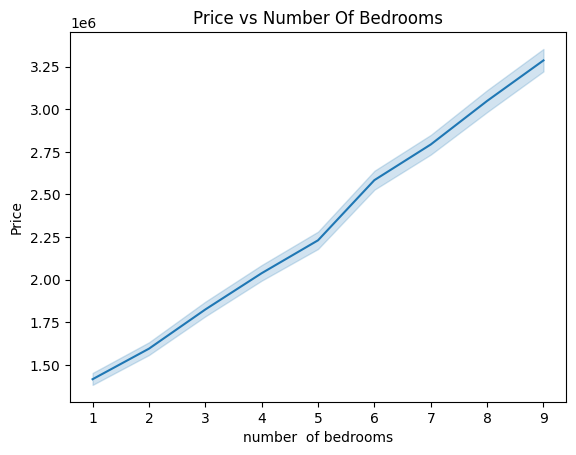

In [31]:
# relationship between the number of bedrooms and the house price
sns.lineplot(data=df_train, x='bedroom', y='price')
plt.title('Price vs Number Of Bedrooms')
plt.xlabel('number  of bedrooms')
plt.ylabel('Price')
plt.show()

<AxesSubplot:xlabel='title'>

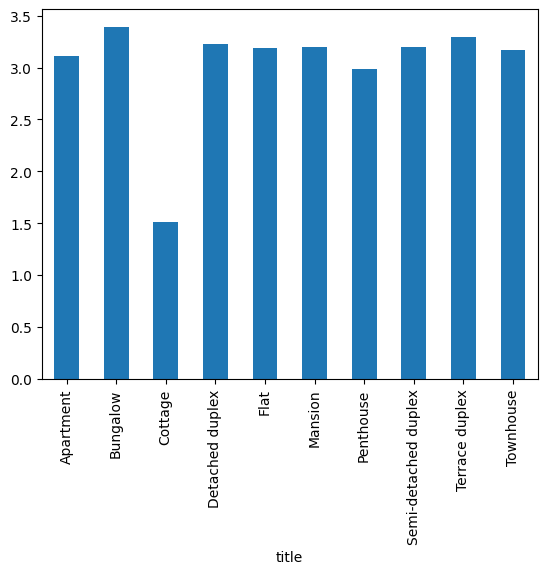

In [34]:
#VWhich house type has the highest average number of bathrooms
df_train.groupby("title")["bathroom"].mean().plot(kind='bar')



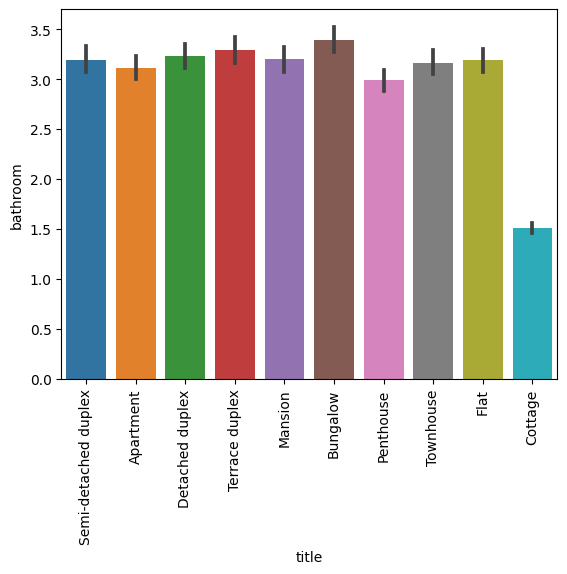

In [37]:
sns.barplot(data=df_train, y="bathroom", x="title")
plt.xticks(rotation = 90);

<AxesSubplot:xlabel='parking_space', ylabel='count'>

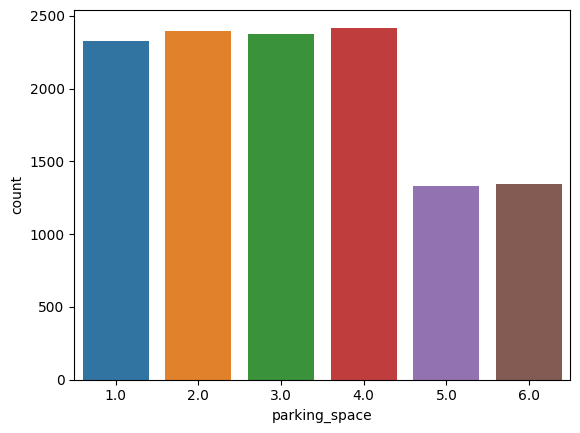

In [40]:
#What is the distribution of the number of cars parking_space can fit

sns.countplot(data=df_train, x='parking_space')

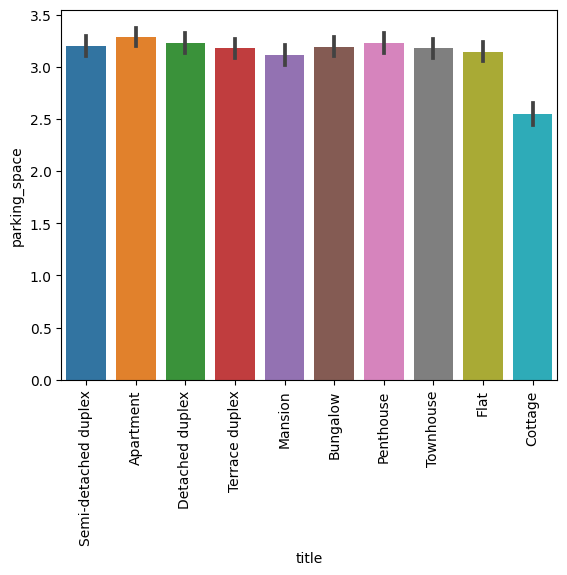

In [51]:
sns.barplot(df_train, x="title", y="parking_space")
plt.xticks(rotation = 90);

<AxesSubplot:xlabel='parking_space', ylabel='title'>

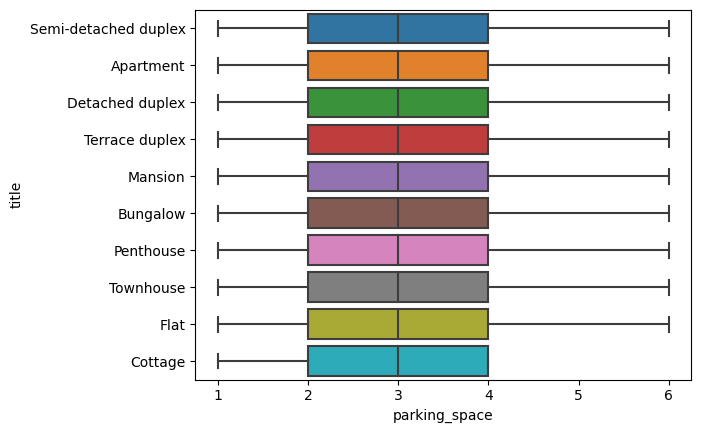

In [49]:
# Create a box plot of parking_space vs title
sns.boxplot(data=df_train, y='title', x='parking_space')



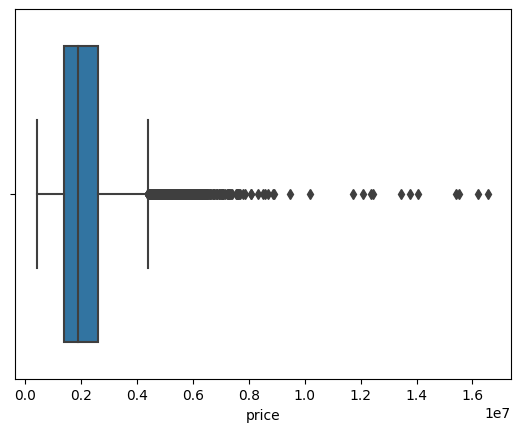

In [55]:

# boxplot to show outliers in price column
sns.boxplot(x=df_train['price'])
plt.show()
# END: 1234abcd
plt.show()


<AxesSubplot:>

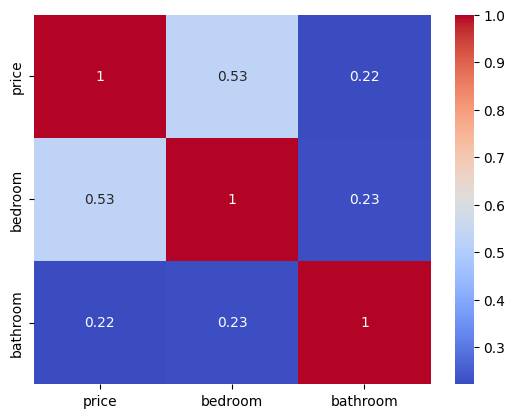

In [71]:
import seaborn as sns

# Create a heatmap of price vs bedrooms and bathrooms
sns.heatmap(df_train[['price', 'bedroom', 'bathroom']].corr(), annot=True, cmap='coolwarm')

In [50]:
# sns.barplot(df_train[df_train["parking_space"].isin([5.0,6.0])], x="title", y="parking_space")
# plt.xticks(rotation = 90);

In [44]:
df_train[df_train["parking_space"].isin([5.0,6.0])]

,ID,loc,title,bedroom,bathroom,parking_space,price
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898
7,3003,Katsina,Penthouse,3.0,3.0,5.0,2043107.592
10,12573,Ogun,Bungalow,1.0,2.0,6.0,1330213.036
12,3753,NaN,NaN,5.0,NaN,5.0,2087592.812
24,10758,Edo,Flat,6.0,7.0,6.0,2446005.185
...,...,...,...,...,...,...,...
13985,2507,Ondo,Bungalow,7.0,2.0,5.0,2441747.040
13994,10477,Taraba,Detached duplex,8.0,1.0,6.0,2837199.086
13996,9704,Kaduna,Apartment,NaN,7.0,5.0,2228516.471
13997,11190,Plateau,Bungalow,8.0,6.0,5.0,2406812.693


In [12]:
# Group the data by 'title' and 'loc' and calculate the mean of 'price'
df_grouped = df_train.groupby(["title", "loc"])["price"].mean().reset_index()

# Convert 'price' column to float
df_grouped["price"] = df_grouped["price"].astype(float)

# Create a bar plot
fig = px.bar(df_grouped, x="loc", y="price", color="title")

fig.show()


In [13]:
len(df["loc"].unique())


37

In [14]:
df_sorted = df.sort_values("bathroom", ascending=False)
df_sorted


,ID,loc,title,bedroom,bathroom,parking_space,price
2743,10964,Nasarawa,Detached duplex,3.0,7.0,4.0,test
289,1277,Kaduna,Bungalow,8.0,7.0,3.0,test
4790,8236,NaN,Townhouse,4.0,7.0,6.0,1809713.52
273,9711,Borno,Flat,9.0,7.0,6.0,test
4912,3312,Benue,Detached duplex,2.0,7.0,4.0,test
...,...,...,...,...,...,...,...
13961,2083,Cross River,Apartment,5.0,NaN,4.0,1925508.334
13962,2069,Taraba,Bungalow,5.0,NaN,2.0,1510809.776
13970,8406,Ebonyi,Flat,7.0,NaN,4.0,2023895.706
13971,2063,Niger,Bungalow,6.0,NaN,2.0,1951550.022


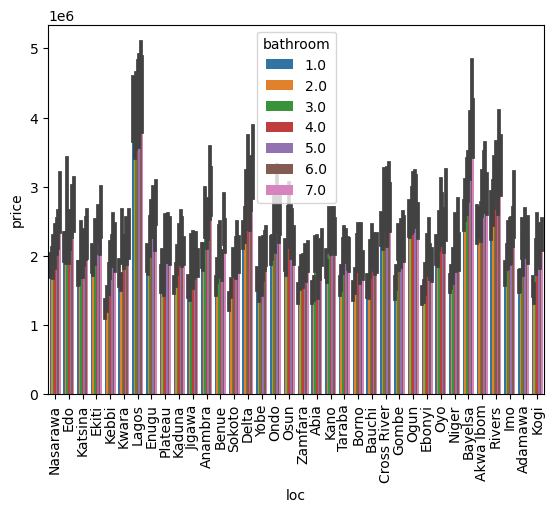

In [15]:
df_sorted = df_train.sort_values("bathroom", ascending=False)
sns.barplot(x="loc", y="price", hue="bathroom", data=df_sorted)
plt.xticks(rotation=90)
plt.show()


In [16]:
import plotly.express as px

fig = px.bar(df_sorted, x="loc", y="price", color="bathroom")
fig.update_layout(xaxis_tickangle=-90)
fig.show()


In [17]:
# plotly line plot highest price per location

max_prices = df_train.groupby("loc")["price"].max().reset_index()

fig = px.line(max_prices, x="loc", y="price", title="Highest Price per Location")
fig.show()


In [18]:
# plotly line plot highest price per title

max_title = df_train.groupby("title")["price"].max().reset_index()

fig = px.line(max_title, x="title", y="price", title="Highest Price per House Type")
fig.show()


In [19]:
# fig = px.scatter_matrix(df_train)
# fig.show()


In [20]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go

df_train_copy = df_train.dropna().copy()

df_train_copy["bedroom"] = df_train_copy["bedroom"].astype(str)
df_train_copy["bathroom"] = df_train_copy["bathroom"].astype(str)
df_train_copy["parking_space"] = df_train_copy["parking_space"].astype(str)

fig = make_subplots(rows=2, cols=3, vertical_spacing=0.2, horizontal_spacing=0.09)

# Create a list of column names and subplot positions
cols = ["bedroom", "bathroom", "parking_space", "loc", "title"]
rows = [1, 1, 1, 2, 2]
positions = [1, 2, 3, 1, 2]

# Iterate through the columns and subplot positions to create the subplots
for col, row, pos in zip(cols, rows, positions):
    fig.add_trace(
        go.Histogram(
            x=df_train_copy[col],
            y=df_train_copy["price"],
            name=col.title(),
        ),
        row=row,
        col=pos,
    )
    fig.update_xaxes(title_text=col.title(), row=row, col=pos)

fig.update_yaxes(title_text="Price")
fig.update_layout(
    title_text="Distribution of Price by Column Values", height=800, width=1200
)

fig.show()


### Correlation Analysis


<AxesSubplot:>

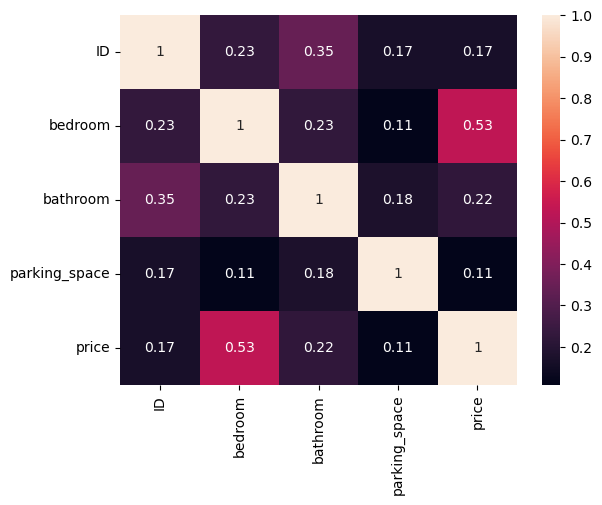

In [21]:
# Calculate the correlation matrix of the training data and plot it as a heatmap.
corr_matrix = df_train.corr()

# Create a heatmap
sns.heatmap(corr_matrix, annot=True)


### Checking for outliers


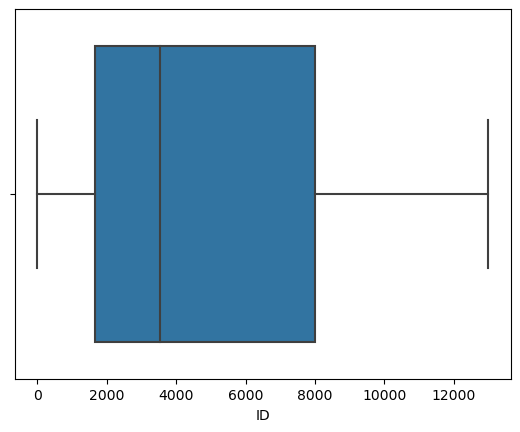

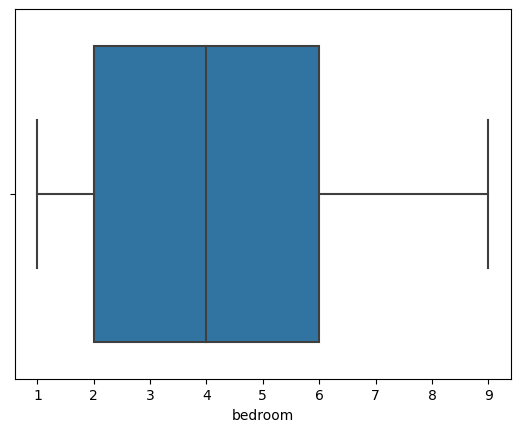

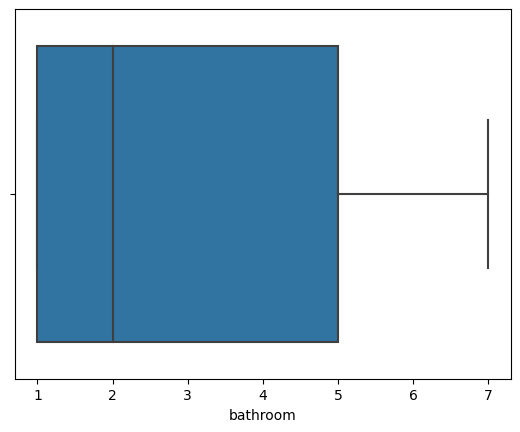

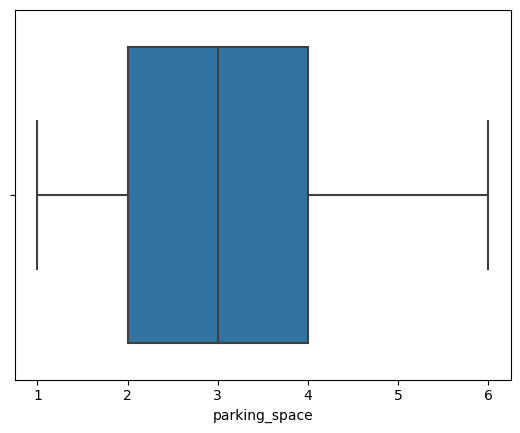

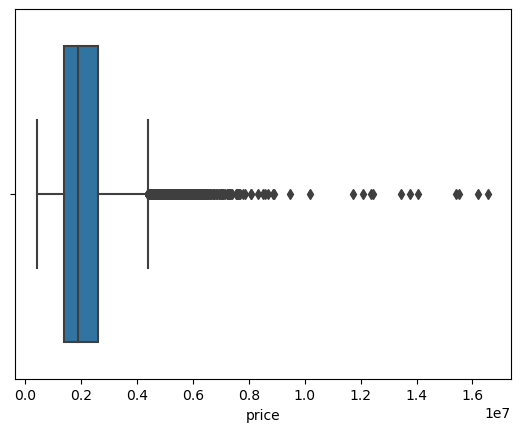

In [22]:
#  ADD ALL PLOTS TO SINGLE PLOT
# Iterate through all columns in the dataframe
for col in df_train.columns:
    # Create a box plot of the column
    if df_train[col].dtype != "object":
        sns.boxplot(x=df_train[col])

        plt.show()


### Filling all missing values


In [23]:
df["bedroom"] = df["bedroom"].fillna(df["bedroom"].mode()[0])
df["bathroom"] = df["bathroom"].fillna(df["bathroom"].mode()[0])
df["parking_space"] = df["parking_space"].fillna(df["parking_space"].mode()[0])
df["loc"] = df["loc"].fillna(df["loc"].mode()[0])
df["title"] = df["title"].fillna(df["title"].mode()[0])


In [24]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 5999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             20000 non-null  int64  
 1   loc            20000 non-null  object 
 2   title          20000 non-null  object 
 3   bedroom        20000 non-null  float64
 4   bathroom       20000 non-null  float64
 5   parking_space  20000 non-null  float64
 6   price          20000 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 1.2+ MB


### Dropping ID column


In [25]:
df = df.drop("ID", axis=1)


In [26]:
df.head()


,loc,title,bedroom,bathroom,parking_space,price
0,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,Ondo,Apartment,5.0,2.0,4.0,1672416.689
2,Ekiti,Flat,7.0,5.0,2.0,3364799.814
3,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,Kogi,Terrace duplex,5.0,5.0,6.0,2600700.898


### Encoding the categorical variables


In [27]:
# label encode the loc and title column

le = LabelEncoder()
df["loc"] = le.fit_transform(df["loc"])
df["title"] = le.fit_transform(df["title"])
df.head()


,loc,title,bedroom,bathroom,parking_space,price
0,19,7,2.0,2.0,1.0,1149999.565
1,27,0,5.0,2.0,4.0,1672416.689
2,12,4,7.0,5.0,2.0,3364799.814
3,3,3,5.0,2.0,4.0,2410306.756
4,21,8,5.0,5.0,6.0,2600700.898


### Train test split


In [28]:
# Divide the dataframe into train and test based on the 'price' column
df_train = df[~df["price"].astype(str).str.contains("test")]
df_test = df[df["price"].astype(str).str.contains("test")]


In [29]:
# Reset the index of the dataframes
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


In [30]:
print(df_train.shape, df_test.shape)


(14000, 6) (6000, 6)


In [31]:
df_test.head()


,loc,title,bedroom,bathroom,parking_space,price
0,18,6,4.0,1.0,2.0,test
1,1,0,2.0,2.0,4.0,test
2,1,1,2.0,7.0,2.0,test
3,23,5,9.0,5.0,2.0,test
4,14,7,5.0,6.0,1.0,test


### Scaling of dataset


In [48]:
X = df_train.drop("price", axis=1)
y = df_train["price"]
X_test = df_test.drop("price", axis=1)
y_test = df_test["price"]


In [49]:
# scale the dataset with standard scaler

scaler = StandardScaler()
train_scaler = scaler.fit(X)
X = train_scaler.transform(X)
# scaler.fit(X_test)
X_test = train_scaler.transform(X_test)


In [50]:
# split dataset

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=7)

print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)


(10500, 5) (3500, 5)
(10500,) (3500,)


### Model Creation


In [51]:
# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the target variable for the test data
y_pred = model.predict(X_val)


In [52]:
# calculate RMSE
from sklearn.metrics import mean_squared_error

mean_squared_error(y_val, y_pred, squared=False)

919199.0583834171

In [53]:
model.fit(X, y)
predictions = model.predict(X_test)

In [54]:
sample_sub = pd.read_csv('data/Sample_submission.csv')
print(sample_sub.shape)
sample_sub.head()

(6000, 1)


,ID
0,845
1,1924
2,10718
3,12076
4,12254


In [56]:
predictions.shape

(6000,)

In [57]:
sample_sub['price'] = predictions
sample_sub.head()

,ID,price
0,845,1.997744e+06
1,1924,1.373012e+06
2,10718,1.628956e+06
3,12076,3.243313e+06
4,12254,2.516887e+06


In [ ]:
sample_sub.to_csv('linear_regression_sub.csv', index=False)

In [35]:
# create a new dataframe called df_pred appending the price predictions to the test data called price_pred
# df_pred = df_test.copy()
# df_test["price_pred"] = predictions
# df_test.head()


,loc,title,bedroom,bathroom,parking_space,price,price_pred
0,18,6,4.0,1.0,2.0,test,1.997827e+06
1,1,0,2.0,2.0,4.0,test,1.423181e+06
2,1,1,2.0,7.0,2.0,test,1.677556e+06
3,23,5,9.0,5.0,2.0,test,3.171797e+06
4,14,7,5.0,6.0,1.0,test,2.499903e+06


### Model Evaluation


In [36]:
# I need the original price for x_test to get past this point

# # Calculate the mean squared error between the predicted and actual values
# mse = mean_squared_error(df_test['price'], predictions)

# # Calculate the root mean squared error
# rmse = np.sqrt(mse)

# print('Root Mean Squared Error:', rmse)


we evaluate the performance of the regression model by visually inspecting the predicted values and comparing them to the actual values in the training data since theres no test data.
This will create a scatter plot of the predicted values versus the actual values in the training data.
A good regression model will have the predicted values close to the actual values along the diagonal line.


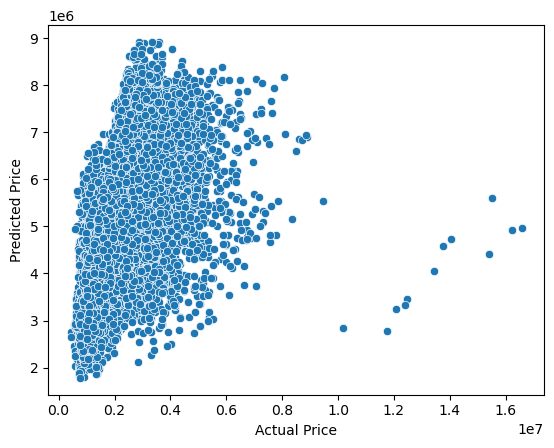

In [37]:
# Create a scatter plot of the predicted vs actual values
sns.scatterplot(x=df_train["price"], y=model.predict(df_train.drop("price", axis=1)))
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()


### Improving model performance


### Ridge regularization


In [38]:
# from sklearn.linear_model import Ridge

# # Create a Ridge regression model with a regularization strength of 0.1
# model = Ridge(alpha=0.1)

# # Train the model on the training data
# model.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = model.predict(X_test)

# # Calculate the RMSE of the model on the test data
# rmse = mean_squared_error(y_test, y_pred, squared=False)

# print('RMSE:', rmse)


### hyper parameter tuning


In [39]:
# Define the hyperparameters to tune
param_grid = {
    "ridge__alpha": [0.1, 1, 10, 100],
    "ridge__fit_intercept": [True, False],
    "polynomialfeatures__degree": [1, 2, 3],
}

# Create a Ridge regression model
model = make_pipeline(PolynomialFeatures(), Ridge())

# Create a grid search object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring="neg_mean_squared_error")

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)


Best hyperparameters: {'polynomialfeatures__degree': 3, 'ridge__alpha': 10, 'ridge__fit_intercept': True}
Best score: 754123736867.7937


I need the original price for x_test to get past this point


In [40]:
from sklearn.metrics import mean_squared_error

# Create a Ridge regression model with the best hyperparameters
model = make_pipeline(
    PolynomialFeatures(degree=grid_search.best_params_["polynomialfeatures__degree"]),
    Ridge(
        alpha=grid_search.best_params_["ridge__alpha"],
        fit_intercept=grid_search.best_params_["ridge__fit_intercept"],
    ),
)

# Train the model on the entire training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the RMSE of the model on the test set
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE:", rmse)


ValueError: could not convert string to float: 'test'